In [1]:
import scanpy as sc
import pandas as pd
import os
import sys
import numpy as np
import gzip
import matplotlib.pyplot as pl
import re
import seaborn as sns
from scipy.io import mmread
from scipy.sparse import csr_matrix
import tqdm.notebook as tq
import shutil
import sys 
sys.path.insert(0, '../')
import utils
from importlib import reload
reload(utils)
from utils import *
data_path = '/ibex/scratch/alsulara/PBMC_Data/'
save_path_results = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Results/"
save_path_data = "/ibex/scratch/alsulara/Cell-Type-Specific-Graphs/Data/"


2024-07-12 15:20:26.702302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-07-12 15:20:30.506456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
var = data_path+'GSE96583_batch2.genes.tsv.gz'
var = pd.read_csv(var, sep='\t', header=None, index_col=0)
var.reset_index(inplace =True)
var = var.rename(columns={0: 'ensemble_id', 1: 'gene_name'})
var.set_index( 'gene_name', inplace = True )
var

,ensemble_id
gene_name,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
MT-ND4L,ENSG00000212907
MT-ND4,ENSG00000198886
MT-ND5,ENSG00000198786


In [3]:
obs = data_path+'GSE96583_batch2.total.tsne.df.tsv.gz'
obs = pd.read_csv(obs, sep='\t')
obs

,tsne1,tsne2,ind,stim,cluster,cell,multiplets
AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet
...,...,...,...,...,...,...,...
TTTGCATGCTAAGC-1,25.142392,6.603815,107,stim,6,CD4 T cells,singlet
TTTGCATGGGACGA-1,14.359657,10.965601,1488,stim,6,CD4 T cells,singlet
TTTGCATGGTGAGG-1,27.317997,7.933458,1488,stim,6,CD4 T cells,ambs
TTTGCATGGTTTGG-1,13.744084,9.347784,1244,stim,6,CD4 T cells,ambs


In [4]:
counts_mat_1 = csr_matrix(mmread(data_path+'GSM2560248_2.1.mtx.gz'))
counts_mat_1.shape

(35635, 14619)

In [5]:
counts_mat_2 = csr_matrix(mmread(data_path+'GSM2560249_2.2.mtx.gz'))
counts_mat_2.shape

(35635, 14446)

In [6]:
barcodes_1 = data_path+'GSM2560248_barcodes.tsv.gz'
barcodes_1 = pd.read_csv(barcodes_1, sep='\t', header = None)
obs_barcodes_1 = obs.loc[barcodes_1[0].tolist()]
obs_barcodes_1

,tsne1,tsne2,ind,stim,cluster,cell,multiplets
AAACATACAATGCC-1,-4.277833,-19.294709,107,ctrl,5,CD4 T cells,doublet
AAACATACATTTCC-1,-27.640373,14.966629,1016,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGAAA-1,-27.493646,28.924885,1256,ctrl,9,CD14+ Monocytes,singlet
AAACATACCAGCTA-1,-28.132584,24.925484,1256,ctrl,9,CD14+ Monocytes,doublet
AAACATACCATGCA-1,-10.468194,-5.984389,1488,ctrl,3,CD4 T cells,singlet
...,...,...,...,...,...,...,...
TTTGCATGCTTCGC-1,-30.296922,-7.644350,101,ctrl,4,B cells,singlet
TTTGCATGGCAGTT-1,-31.202417,7.029632,1016,ctrl,9,FCGR3A+ Monocytes,singlet
TTTGCATGGGAACG-1,17.791388,-21.583107,1016,ctrl,10,CD8 T cells,singlet
TTTGCATGGTCCTC-1,-25.741550,-13.367704,1256,ctrl,4,B cells,singlet


In [7]:
barcodes_2 = data_path+'GSM2560249_barcodes.tsv.gz'
barcodes_2 = pd.read_csv(barcodes_2, sep='\t', header =None)
obs_barcodes_2 = obs.loc[barcodes_2[0].tolist()]
obs_barcodes_2

,tsne1,tsne2,ind,stim,cluster,cell,multiplets
AAACATACCAAGCT-1,26.198495,-6.930392,101,stim,10,CD8 T cells,singlet
AAACATACCCCTAC-1,31.002792,21.730184,1488,stim,2,Dendritic cells,singlet
AAACATACCCGTAA-1,3.992437,11.494216,1244,stim,6,CD4 T cells,ambs
AAACATACCCTCGT-1,-15.655645,4.109124,1488,stim,4,B cells,singlet
AAACATACGAGGTG-1,5.987393,3.533825,1488,stim,6,CD4 T cells,singlet
...,...,...,...,...,...,...,...
TTTGCATGCTAAGC-1,25.142392,6.603815,107,stim,6,CD4 T cells,singlet
TTTGCATGGGACGA-1,14.359657,10.965601,1488,stim,6,CD4 T cells,singlet
TTTGCATGGTGAGG-1,27.317997,7.933458,1488,stim,6,CD4 T cells,ambs
TTTGCATGGTTTGG-1,13.744084,9.347784,1244,stim,6,CD4 T cells,ambs


In [8]:
adata_list = []
adata_1 = sc.AnnData(counts_mat_1.T, obs=obs_barcodes_1)
adata_1 = adata_1[ ~ adata_1.obs.multiplets.isin(['doublet', 'ambs']) ]
adata_1.var_names_make_unique()
adata_1.obs_names_make_unique()
adata_list.append(adata_1)
adata_1

AnnData object with n_obs × n_vars = 12315 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'

In [9]:
adata_2 = sc.AnnData(counts_mat_2.T, obs=obs_barcodes_2)
adata_2 = adata_2[ ~ adata_2.obs.multiplets.isin(['doublet', 'ambs']) ]
adata_2.var_names_make_unique()
adata_2.obs_names_make_unique()
adata_list.append(adata_2)
adata_2

AnnData object with n_obs × n_vars = 12285 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'

In [10]:
adata = sc.concat(adata_list, axis = 0, join = 'outer')
adata.var = var
adata.var_names_make_unique()
adata.obs_names_make_unique()

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata

AnnData object with n_obs × n_vars = 24600 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets'
    var: 'ensemble_id'

In [12]:
adata.obs.stim.value_counts()

stim
ctrl    12549
stim    12051
Name: count, dtype: int64

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))

In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

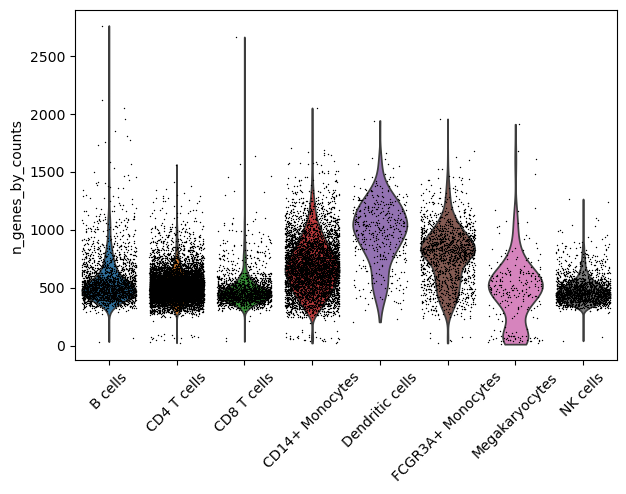

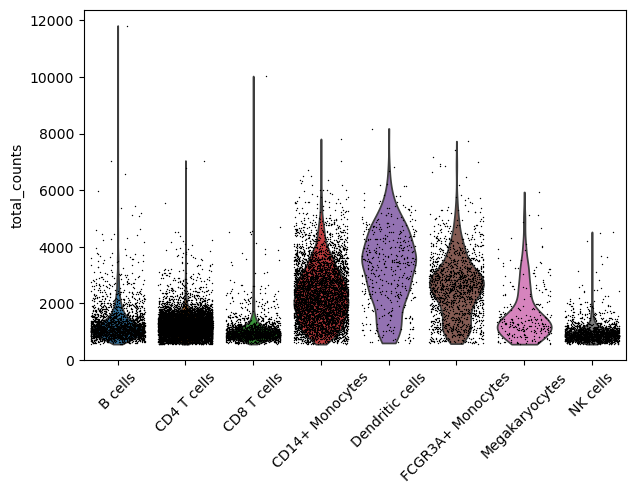

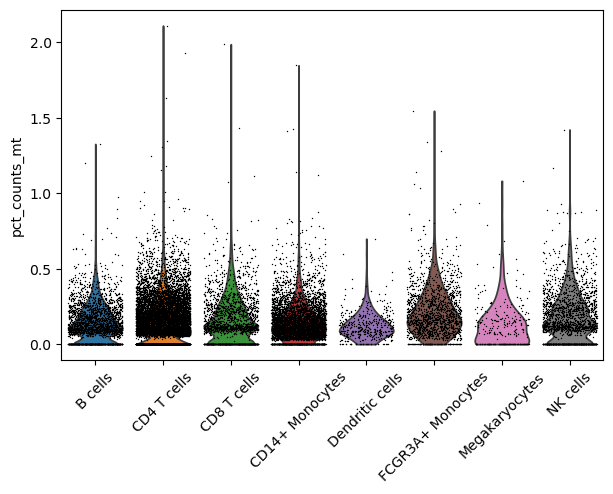

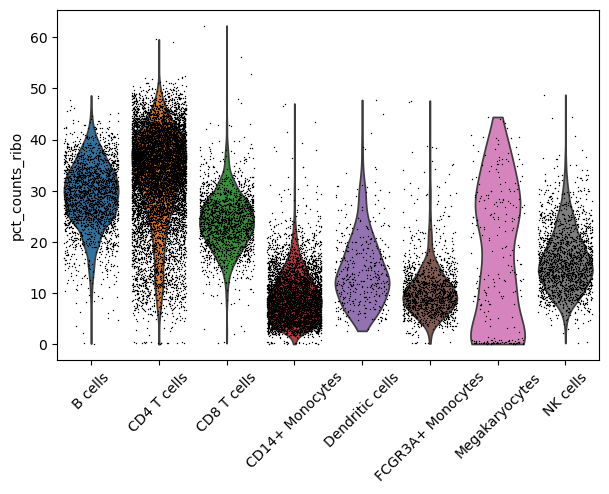

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

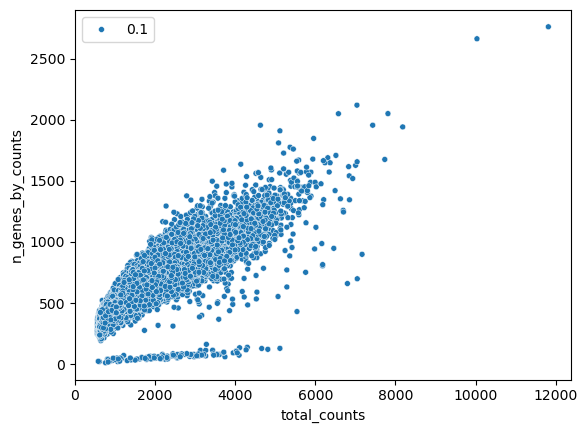

In [15]:
adata.obs['cluster'] = pd.Categorical(adata.obs['cluster'])
sc.pl.violin(adata, ['n_genes_by_counts'] #, 'total_counts','pct_counts_mt', 'pct_counts_ribo']
             ,jitter=0.4, groupby = 'cell', rotation= 45)
sc.pl.violin(adata, ['total_counts'] #,'pct_counts_mt', 'pct_counts_ribo']
             ,jitter=0.4, groupby = 'cell', rotation= 45)
sc.pl.violin(adata, ['pct_counts_mt'] #,'pct_counts_mt', 'pct_counts_ribo']
             ,jitter=0.4, groupby = 'cell', rotation= 45)
sc.pl.violin(adata, ['pct_counts_ribo'] #,'pct_counts_mt', 'pct_counts_ribo']
             ,jitter=0.4, groupby = 'cell', rotation= 45)
sns.scatterplot(data=adata.obs, x="total_counts", y="n_genes_by_counts", size = 0.1)


<Axes: xlabel='total_counts', ylabel='pct_counts_mt'>

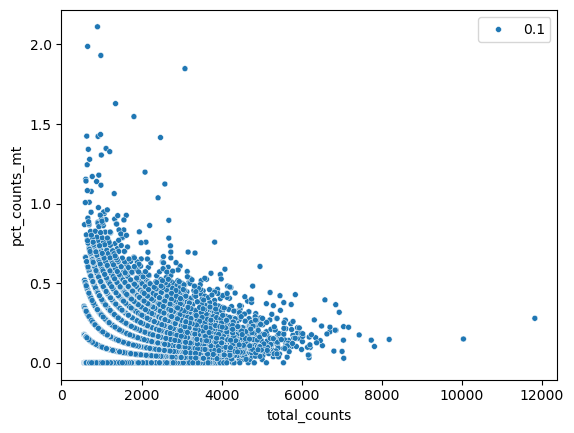

In [16]:
sns.scatterplot(data=adata.obs, x="total_counts", y="pct_counts_mt", size = 0.1)

In [17]:
adata = adata[adata.obs.n_genes_by_counts >= 200]
adata = adata[adata.obs.pct_counts_mt <= 1.0]
adata = adata[adata.obs.cell != 'Megakaryocytes']
adata = adata[:, adata.var.mt == False]
adata = adata[:, adata.var.ribo == False]
adata

View of AnnData object with n_obs × n_vars = 24249 × 35398
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_colors'

In [18]:
adata.obs.rename({"cell": "cell_type"}, axis=1, inplace=True)
adata.obs.rename({"stim": "condition"}, axis=1, inplace=True)
adata.obs.rename({"ind": "replicate"}, axis=1, inplace=True)
adata.obs["condition"].replace({"ctrl": "control", "stim": "stimulated"}, inplace=True)
adata.layers['counts'] = adata.X 
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [19]:
sc.pp.highly_variable_genes(adata, subset=True, n_top_genes = 5000)
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'log1p', 'hvg'
    layers: 'counts'

In [20]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alsulara/miniconda3/envs/Perturb

In [21]:
adata.obs['replicate'] = adata.obs['replicate'].astype(str)
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/alsulara/miniconda3/envs/Perturbation_Project/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


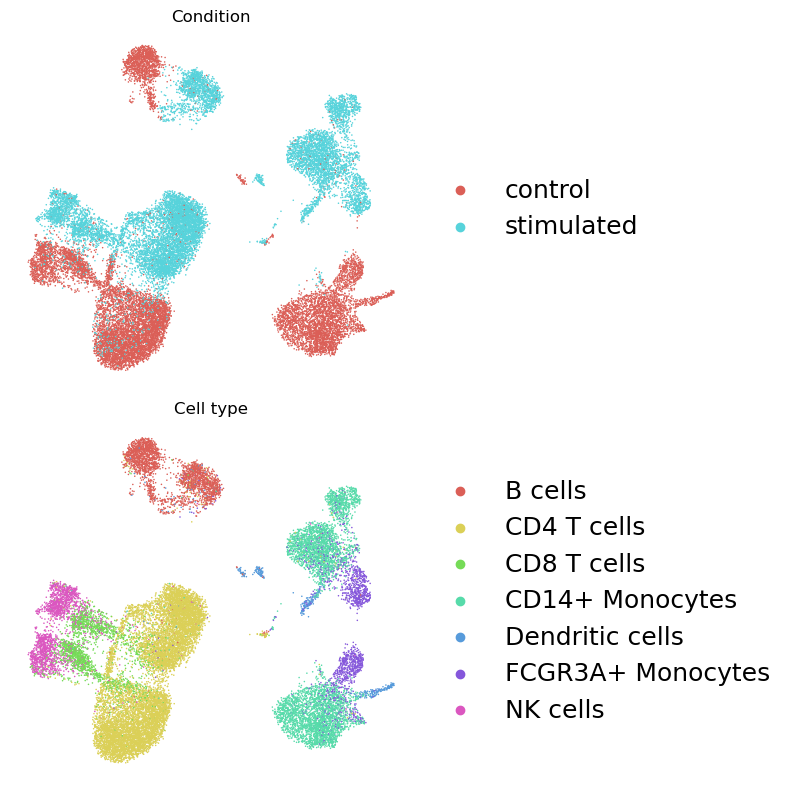

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 8))  # Adjust figsize as needed
# Plot UMAP 1 in the first subplot if it's not empty
sc.pl.umap(adata=adata, color=["condition"],legend_fontsize=18,ax = axes[0],
           title = "Condition",
           show=False, palette = sns.color_palette("hls", 2),
           frameon=False)

sc.pl.umap(adata=adata, color=["cell_type"],legend_fontsize=18,ax = axes[1],
           title = "Cell type",
           show=False, palette = sns.color_palette("hls", 7),
           frameon=False)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(save_path_results+"PBMC_UMAP.pdf")
# Show the merged plot
plt.show()

In [23]:
adata.layers['counts'].A.max()
adata.X.A.max()

6.362065

In [24]:
#pd.read_csv(data_path+'GSE96583_batch1.total.tsne.df.tsv.gz', sep = "\t")
adata[adata.obs.condition == 'stimulated'].copy().obs.cell_type.value_counts()

cell_type
CD4 T cells          5087
CD14+ Monocytes      2512
B cells              1230
NK cells             1046
CD8 T cells           937
FCGR3A+ Monocytes     825
Dendritic cells       224
Name: count, dtype: int64

In [25]:
adata[adata.obs.condition == 'control'].copy().obs.cell_type.value_counts()

cell_type
CD4 T cells          5242
CD14+ Monocytes      2828
B cells              1329
CD8 T cells          1096
NK cells              933
FCGR3A+ Monocytes     753
Dendritic cells       207
Name: count, dtype: int64

In [26]:
adata.obs['cov_cond'] = adata.obs.cell_type.astype(str) + '_' + adata.obs.condition.astype(str)


In [27]:
adata.write(save_path_data+'PBMC.h5ad')

In [28]:
adata

AnnData object with n_obs × n_vars = 24249 × 5000
    obs: 'tsne1', 'tsne2', 'replicate', 'condition', 'cluster', 'cell_type', 'multiplets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cov_cond'
    var: 'ensemble_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [29]:
ctrl = adata[adata.obs.condition == 'control'].copy()
ctrl.obs.replicate.value_counts()
pd.crosstab(adata.obs['cell_type'],adata.obs['replicate'])

replicate,101,107,1015,1016,1039,1244,1256,1488
cell_type,,,,,,,,
B cells,239,99,798,234,64,212,420,493
CD4 T cells,663,344,1582,770,447,1926,1944,2653
CD8 T cells,178,34,312,1022,55,89,241,102
CD14+ Monocytes,449,375,1446,700,260,706,770,634
Dendritic cells,55,21,60,34,27,80,58,96
FCGR3A+ Monocytes,218,67,475,241,74,91,168,244
NK cells,174,84,371,315,42,219,494,280
